Computing LOS integrals...


100%|██████████| 16200/16200 [00:00<00:00, 41793.15it/s]


Rotating sky into detector frame over time...


  0%|          | 0/2000 [00:00<?, ?it/s]WARNING: Tried to get polar motions for times after IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the arcsec level. Please check your astropy.utils.iers.conf.iers_auto_url and point it to a newer version if necessary. [astropy.coordinates.builtin_frames.utils]
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
  0%|          | 1/2000 [00:00<09:16,  3.59it/s]/tmp/ipykernel_11050/2258078034.py:86: RuntimeWarning: invalid value encountered in arccos
  theta_det = np.arccos(z_det)
100%|██████████| 2000/2000 [00:19<00:00, 101.14it/s]


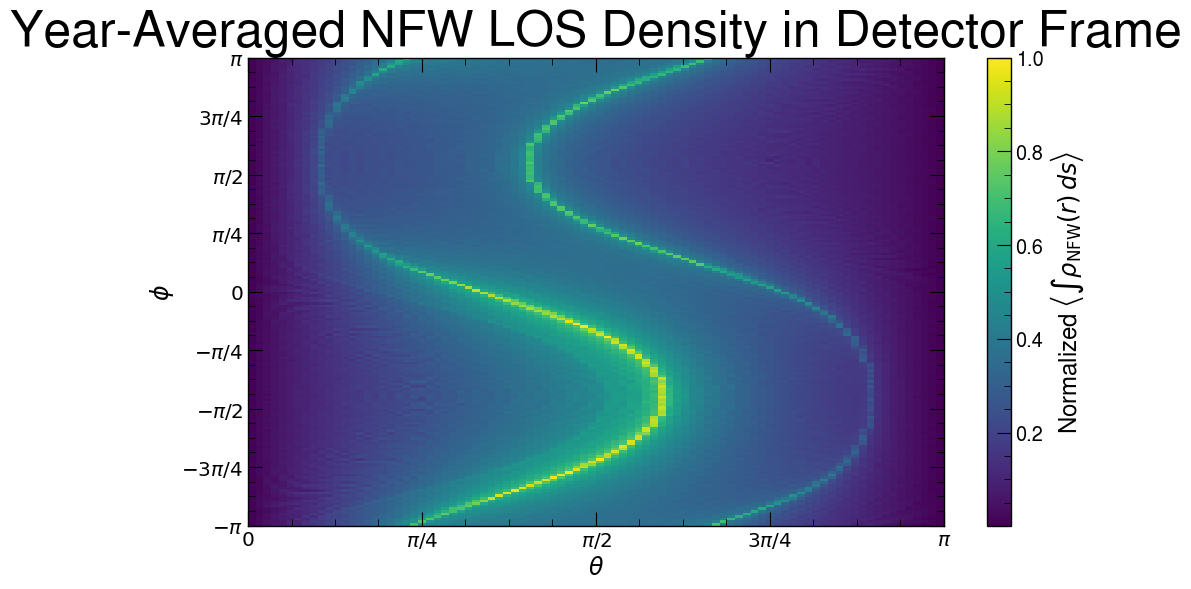

In [2]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # optional: progress bar

# Constants
r_s = 20.0  # kpc #20.0
rho_0 = 0.184  # GeV/cm^3
R_sun = 8.122  # kpc

def rho_NFW(r):
    return rho_0 * (r_s / r) / (1 + r / r_s)**2

def r_galcen(l_deg, b_deg, s):
    l_rad = np.radians(l_deg)
    b_rad = np.radians(b_deg)
    return np.sqrt(R_sun**2 + s**2 - 2 * R_sun * s * np.cos(b_rad) * np.cos(l_rad))

def los_integral(l, b, s_max=300, steps=1000):
    s_vals = np.linspace(0.01, s_max, steps)
    r_vals = r_galcen(l, b, s_vals)
    rho_vals = rho_NFW(r_vals)
    return np.trapz(rho_vals, s_vals)


# --- Grid in Galactic coordinates (full sky) ---
n_lat = 90
n_lon = 180
l_vals = np.linspace(0, 360, n_lon )

b_vals = np.linspace(-90, 90, n_lat)
L, B = np.meshgrid(l_vals, b_vals)
l_flat = L.flatten()
b_flat = B.flatten()
coords_gal = SkyCoord(l=l_flat*u.deg, b=b_flat*u.deg, frame='galactic')

# --- Set detector location ---
location = EarthLocation(lat=43.8206*u.deg, lon=-103.7436*u.deg, height=100*u.m)

# --- Time sampling over one year ---
n_times = 2000  # increase for smoother results
start_time = Time("2030-01-01 00:00:00")
end_time = start_time + 1 * u.year
times = Time(np.linspace(start_time.jd, end_time.jd, n_times), format='jd')

# --- Detector rotation matrix (AltAz → Detector frame) ---
FluxRotValues = np.array([
    [+0.9877, -0.1564, +0.0000],
    [+0.0000, +0.0000, +1.0000],
    [-0.1564, -0.9877, +0.0000]
])

# --- Bin edges for histogram ---
n_theta_bins = 90
n_phi_bins = 180
theta_edges = np.linspace(0, np.pi, n_theta_bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, n_phi_bins + 1)

# --- Accumulator for histogram counts ---
accum_weights = np.zeros((n_phi_bins, n_theta_bins))

# --- Precompute LOS integrals once (doesn't depend on time) ---
print("Computing LOS integrals...")
rho_vals = np.array([los_integral(l, b) for l, b in tqdm(zip(l_flat, b_flat), total=len(l_flat))])
rho_vals /= np.max(rho_vals)  # normalize

# --- Loop over time to accumulate intensity maps ---
print("Rotating sky into detector frame over time...")
for time in tqdm(times):
    # Convert to AltAz frame
    coords_altaz = coords_gal.transform_to(AltAz(obstime=time, location=location))
    alt_rad = coords_altaz.alt.radian
    az_rad = coords_altaz.az.radian

    # Convert to local frame Cartesian
    x = np.cos(alt_rad) * np.sin(az_rad)
    y = np.cos(alt_rad) * np.cos(az_rad)
    z = np.sin(alt_rad)
    arr_local = np.stack([x, y, z], axis=0)

    # Rotate to detector frame
    arr_det = FluxRotValues @ arr_local
    x_det, y_det, z_det = arr_det
    theta_det = np.arccos(z_det)
    phi_det = np.arctan2(y_det, x_det)
    #phi_det = np.mod(phi_det, 2 * np.pi)      # shift to [0, 2pi]
    phi_det[phi_det > np.pi] -= 2 * np.pi

    # Accumulate histogram with LOS weights
    H, _, _ = np.histogram2d(phi_det, theta_det,
                             bins=[phi_edges, theta_edges],
                             weights=rho_vals)
    accum_weights += H

# --- Normalize the accumulated map ---
accum_weights /= np.max(accum_weights)



# --- Plot result ---
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
mesh = ax.pcolormesh(theta_edges, phi_edges, accum_weights, cmap='viridis', shading='auto')

ax.set_xlabel(r'$\theta$', fontsize=17)
ax.set_ylabel(r'$\phi$', fontsize=17)
ax.set_title("Year-Averaged NFW LOS Density in Detector Frame")

# Tick labels
ax.set_xticks([0.0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels([r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

ax.set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_yticklabels([r'$-\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'$-\pi/4$', r'$0$', r'$\pi/4$',
                    r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

fig.colorbar(mesh, ax=ax, label=r'Normalized $\left< \int \rho_{\rm NFW}(r)\, ds \right>$')
plt.tight_layout()
plt.show()


In [ ]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, Galactic
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # optional: progress bar
import dunestyle.matplotlib as dunestyle

# Constants
r_s = 20.0  # kpc #20.0
rho_0 = 0.184  # GeV/cm^3
R_sun = 8.122  # kpc

def rho_NFW(r):
    return rho_0 * (r_s / r) / (1 + r / r_s)**2

def r_galcen(l_deg, b_deg, s):
    l_rad = np.radians(l_deg)
    b_rad = np.radians(b_deg)
    return np.sqrt(R_sun**2 + s**2 - 2 * R_sun * s * np.cos(b_rad) * np.cos(l_rad))

def los_integral(l, b, s_max=300, steps=1000):
    s_vals = np.linspace(0.01, s_max, steps)
    r_vals = r_galcen(l, b, s_vals)
    rho_vals = rho_NFW(r_vals)
    return np.trapz(rho_vals, s_vals)


# --- Grid in Galactic coordinates (full sky) ---
n_lat = 90
n_lon = 180
l_vals = np.linspace(0, 360, n_lon )

b_vals = np.linspace(-90, 90, n_lat)
L, B = np.meshgrid(l_vals, b_vals)
l_flat = L.flatten()
b_flat = B.flatten()

alt_vals = np.linspace(-90,90,n_lat)
az_vals = np.linspace(0,360,n_lon)

alt,az = np.meshgrid(alt_vals,az_vals)


coords_gal = SkyCoord(l=l_flat*u.deg, b=b_flat*u.deg, frame='galactic')

# --- Set detector location ---
location = EarthLocation(lat=43.8206*u.deg, lon=-103.7436*u.deg, height=100*u.m)

# --- Time sampling over one year ---
n_times = 5  # increase for smoother results
start_time = Time("2030-01-01 00:00:00")
end_time = start_time + 1 * u.year
times = Time(np.linspace(start_time.jd, end_time.jd, n_times), format='jd')

# --- Detector rotation matrix (AltAz → Detector frame) ---
FluxRotValues = np.array([
    [+0.9877, -0.1564, +0.0000],
    [+0.0000, +0.0000, +1.0000],
    [-0.1564, -0.9877, +0.0000]
])

n_alt_bins = 90
n_az_bins = 180
alt_edges = np.linspace(-90, 90, n_alt_bins + 1)
az_edges = np.linspace(0, 360, n_az_bins + 1)

# Centers
alt_centers = 0.5 * (alt_edges[:-1] + alt_edges[1:])
az_centers = 0.5 * (az_edges[:-1] + az_edges[1:])
ALT, AZ = np.meshgrid(alt_centers, az_centers)


ALT_flat = ALT.flatten()
AZ_flat = AZ.flatten()

# --- DUNE location
dune_location = EarthLocation(lat=44.352*u.deg, lon=-103.751*u.deg, height=100*u.m)


# --- Precompute LOS integrals once (doesn't depend on time) ---

rho_vals_i = []
rho_vals = np.zeros(len(ALT_flat))

theta_arr_det = []
theta_arr = []

phi_arr_det = []
phi_arr = []


# --- Loop over time to accumulate intensity maps ---
print("Rotating sky into detector frame over time...")
for time in tqdm(times):
    # Convert to AltAz frame
    rho_vals_i = []
    for alt,az in tqdm(zip(ALT_flat,AZ_flat), total=len(ALT_flat)):
        
        # Compute Galactic coordinates for all AltAz at this time
        altaz = AltAz(alt=alt*u.deg, az=az*u.deg, location=dune_location, obstime=time)
        gal = altaz.transform_to(Galactic())  

        
        l_deg = gal.l.deg
        b_deg = gal.b.deg
        
        rho_vals_i.append(los_integral(l_deg,b_deg))
    
    
    # Convert to NumPy array and accumulate
    rho_vals += np.array(rho_vals_i)
    
    

rho_vals /= np.max(rho_vals)

#x,y,z,x_det,y_det,z_det = []


for alt,az in tqdm(zip(ALT_flat,AZ_flat), total=len(ALT_flat)):
          
    alt_rad = np.radians(alt)
    az_rad = np.radians(az)
    
    # Convert to local frame Cartesian
    x = np.cos(alt_rad) * np.sin(az_rad)
    y = np.cos(alt_rad) * np.cos(az_rad)
    z = np.sin(alt_rad)
    
    theta = np.arccos(z)
    phi = np.arctan2(y, x)

    theta_arr.append(theta)
    phi_arr.append(phi)

    # --- Convert (theta, phi) to Cartesian unit vectors ---
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    vecs = np.stack([x, y, z], axis=0)  # shape: (3, N)
    
    
    vecs_rot = FluxRotValues @ vecs
    x_r, y_r, z_r = vecs_rot
    # Convert to spherical coordinates
    theta_arr_det.append(np.arccos(z_r))              # angle from zenith [0, pi]
    phi_arr_det.append(np.arctan2(y_r, x_r))            # azimuth from south [-pi, pi]


    






/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Rotating sky into detector frame over time...


  0%|          | 0/5 [00:00<?, ?it/s]WARNING: Tried to get polar motions for times after IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the arcsec level. Please check your astropy.utils.iers.conf.iers_auto_url and point it to a newer version if necessary. [astropy.coordinates.builtin_frames.utils]
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
100%|██████████| 16200/16200 [00:00<00:00, 68578.65it/s]


In [74]:
print(len(theta_arr_det), len(phi_arr_det), len(rho_vals))

16200 16200 16200


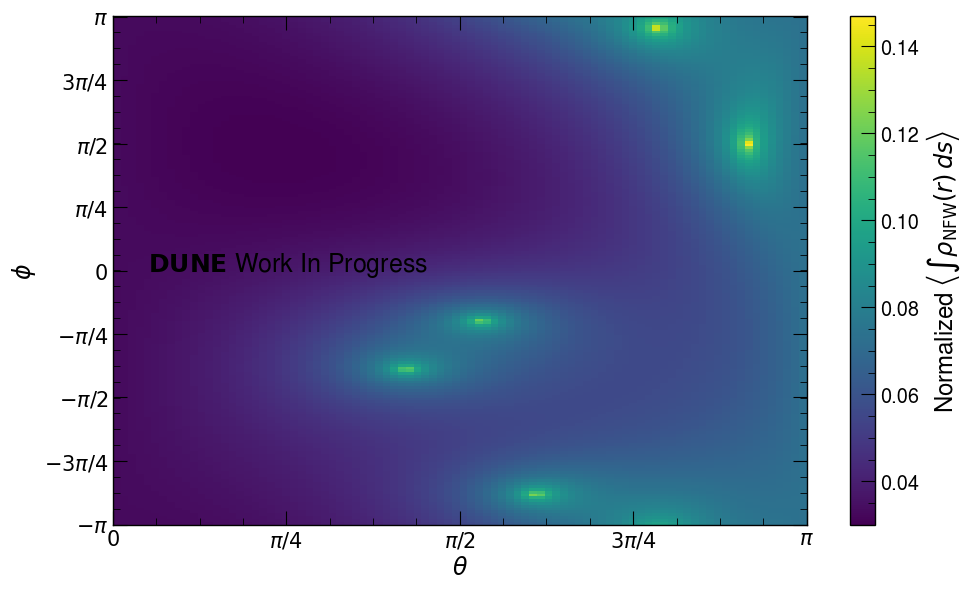

In [77]:
# Create the histogram again in the same style for comparison

fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

# Use the previously computed theta and phi_signed, and normalized intensity
h = ax.hist2d(theta_arr, phi_arr, weights=rho_vals,
              bins=[theta_edges, np.linspace(-np.pi, np.pi, n_phi_bins + 1)],
               cmap='viridis',density =1 )

#gc_scatter = plt.scatter(theta_gc,phi_gc, marker='.', color='red', label = r'$\bf{GC\;Position}$', s =0.1)



# Axis labels
ax.set_xlabel(r'$\theta$', fontsize=17)
ax.set_ylabel(r'$\phi$', fontsize=17)

# X-axis ticks and labels
ax.set_xticks([0.0, 0.78539, 1.570, 2.356, 3.14159])
ax.set_xticklabels([r'$0$', r'$\pi / 4$', r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize=15)

# Y-axis ticks and labels
ax.set_yticks([-3.14159, -2.356, -1.570, -0.78539, 0.0, 0.78539, 1.570, 2.356, 3.14159])
ax.set_yticklabels([r'$-\pi$', r'$-3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$', r'$0$',
                    r'$\pi / 4$', r'$\pi / 2$', r'$3\pi / 4$', r'$\pi$'], fontsize=15)

# Add colorbar
fig.colorbar(h[3], ax=ax, label=r'Normalized $\left< \int \rho_\mathrm{NFW}(r)\, ds \right>$')
#lgnd = plt.legend(handles=[gc_scatter],fontsize=14, frameon=True, framealpha=0.05)

# Fix marker size using the handles returned by legend
#for handle in lgnd.legend_handles:
#    handle.set_sizes([30])  # marker size in points²
    
# Optional DUNE style label
try:
    dunestyle.WIP(x=0.05, y=0.50)
except:
    pass

plt.tight_layout()
plt.show()



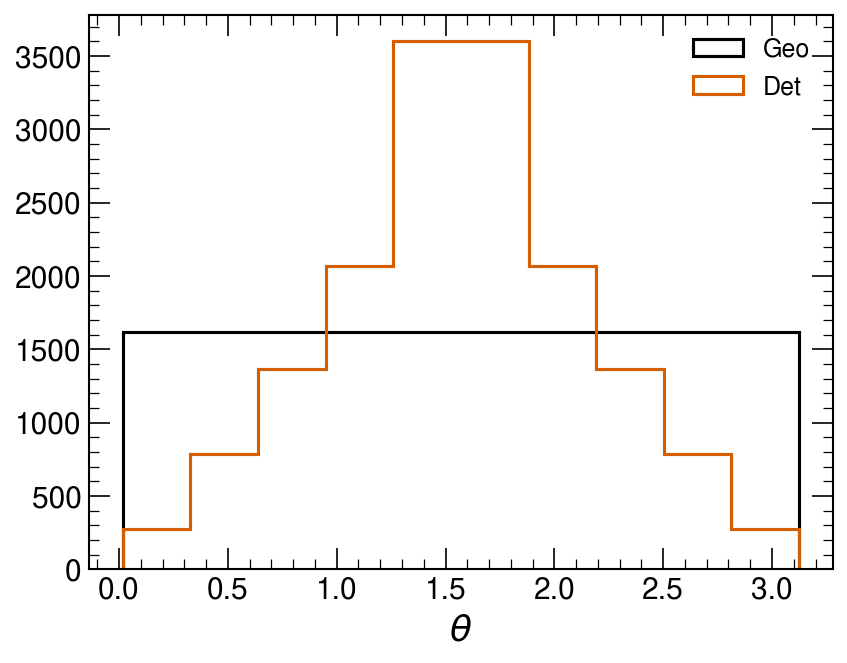

In [32]:
plt.figure(dpi=150)
plt.hist(theta_arr, histtype='step',label='Geo')
plt.hist(theta_det_arr, histtype='step',label='Det')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()

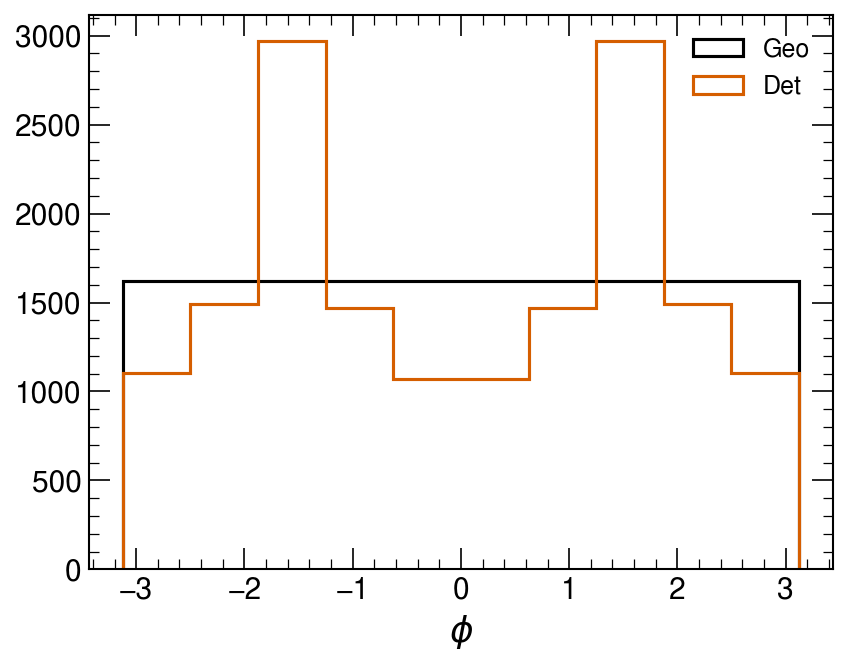

In [34]:
plt.figure(dpi=150)
plt.hist(phi_arr, histtype='step',label='Geo')
plt.hist(phi_det_arr, histtype='step',label='Det')
plt.xlabel(r'$\phi$')
plt.legend()
plt.show()

In [3]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, Galactic
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # optional: progress bar
import dunestyle.matplotlib as dunestyle

# Constants
r_s = 20.0  # kpc #20.0
rho_0 = 0.184  # GeV/cm^3
R_sun = 8.122  # kpc

def rho_NFW(r):
    return rho_0 * (r_s / r) / (1 + r / r_s)**2

def r_galcen(l_deg, b_deg, s):
    l_rad = np.radians(l_deg)
    b_rad = np.radians(b_deg)
    return np.sqrt(R_sun**2 + s**2 - 2 * R_sun * s * np.cos(b_rad) * np.cos(l_rad))

def los_integral(l, b, s_max=300, steps=1000):
    s_vals = np.linspace(0.01, s_max, steps)
    r_vals = r_galcen(l, b, s_vals)
    rho_vals = rho_NFW(r_vals)
    return np.trapz(rho_vals, s_vals)


# --- Grid in Galactic coordinates (full sky) ---
n_lat = 90
n_lon = 180
l_vals = np.linspace(0, 360, n_lon )

b_vals = np.linspace(-90, 90, n_lat)
L, B = np.meshgrid(l_vals, b_vals)
l_flat = L.flatten()
b_flat = B.flatten()


coords_gal = SkyCoord(l=l_flat*u.deg, b=b_flat*u.deg, frame='galactic')

# --- Set detector location ---
location = EarthLocation(lat=43.8206*u.deg, lon=-103.7436*u.deg, height=100*u.m)

# --- Time sampling over one year ---
n_times = 50  # increase for smoother results
start_time = Time("2030-01-01 00:00:00")
end_time = start_time + 1 * u.year
times = Time(np.linspace(start_time.jd, end_time.jd, n_times), format='jd')

# --- Detector rotation matrix (AltAz → Detector frame) ---
FluxRotValues = np.array([
    [+0.9877, -0.1564, +0.0000],
    [+0.0000, +0.0000, +1.0000],
    [-0.1564, -0.9877, +0.0000]
])

n_alt_bins = 90
n_az_bins = 180
alt_edges = np.linspace(-90, 90, n_alt_bins + 1)
az_edges = np.linspace(0, 360, n_az_bins + 1)

# Centers
alt_centers = 0.5 * (alt_edges[:-1] + alt_edges[1:])
az_centers = 0.5 * (az_edges[:-1] + az_edges[1:])
ALT, AZ = np.meshgrid(alt_centers, az_centers)


ALT_flat = ALT.flatten()
AZ_flat = AZ.flatten()

# --- DUNE location
dune_location = EarthLocation(lat=44.352*u.deg, lon=-103.751*u.deg, height=100*u.m)


# --- Precompute LOS integrals once (doesn't depend on time) ---
print("Computing LOS integrals...")
rho_vals_i = []
rho_vals = np.zeros(len(ALT_flat))
rho_vals_replace = np.zeros(len(ALT_flat))

theta_det_arr = []
theta_arr = []

phi_det_arr = []
phi_arr = []


# --- Loop over time to accumulate intensity maps ---
print("Rotating sky into detector frame over time...")
for time in tqdm(times):
    # Convert to AltAz frame
    rho_vals_i = []
    for alt,az in tqdm(zip(ALT_flat,AZ_flat), total=len(ALT_flat)):
        
        # Compute Galactic coordinates for all AltAz at this time
        altaz = AltAz(alt=alt*u.deg, az=az*u.deg, location=dune_location, obstime=time)
        gal = altaz.transform_to(Galactic())  

        
        l_deg = gal.l.deg
        b_deg = gal.b.deg
        
        rho_vals_i.append(los_integral(l_deg,b_deg))
    
    
    # Convert to NumPy array and accumulate
    rho_vals += np.array(rho_vals_i)
    rho_vals_replace += np.array(rho_vals_i)
    

rho_vals /= np.max(rho_vals)
rho_vals_replace /= np.max(rho_vals_replace)

x,y,z,x_det,y_det,z_det = []


for alt,az in tqdm(zip(ALT_flat,AZ_flat), total=len(ALT_flat)):
          
    alt_rad = np.radians(alt)
    az_rad = np.radians(az)
    
    # Convert to local frame Cartesian
    x.append( np.cos(alt_rad) * np.sin(az_rad))
    y.append( np.cos(alt_rad) * np.cos(az_rad))
    z.append( np.sin(alt_rad))
    
    
    
    arr_local = np.array([x, y, z])

    # Convert to spherical coordinates
    #theta_arr.append(np.arccos(z))              # angle from zenith [0, pi]
    #phi_arr.append(np.arctan2(y, x))            # azimuth from south [-pi, pi]


    arr_det = FluxRotValues.dot(arr_local)
    
    
    x_det.append( arr_det[0])
    y_det.append( arr_det[1])
    z_det.append( arr_det[2])
    #theta_det_arr.append(np.arccos(z_det))
    #phi_det_arr.append(np.arctan2(y_det, x_det))






/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Computing LOS integrals...
Rotating sky into detector frame over time...


  0%|          | 0/50 [00:00<?, ?it/s]WARNING: Tried to get polar motions for times after IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the arcsec level. Please check your astropy.utils.iers.conf.iers_auto_url and point it to a newer version if necessary. [astropy.coordinates.builtin_frames.utils]
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
100%|██████████| 50/50 [26:57<00:00, 32.36s/it]


ValueError: not enough values to unpack (expected 6, got 0)

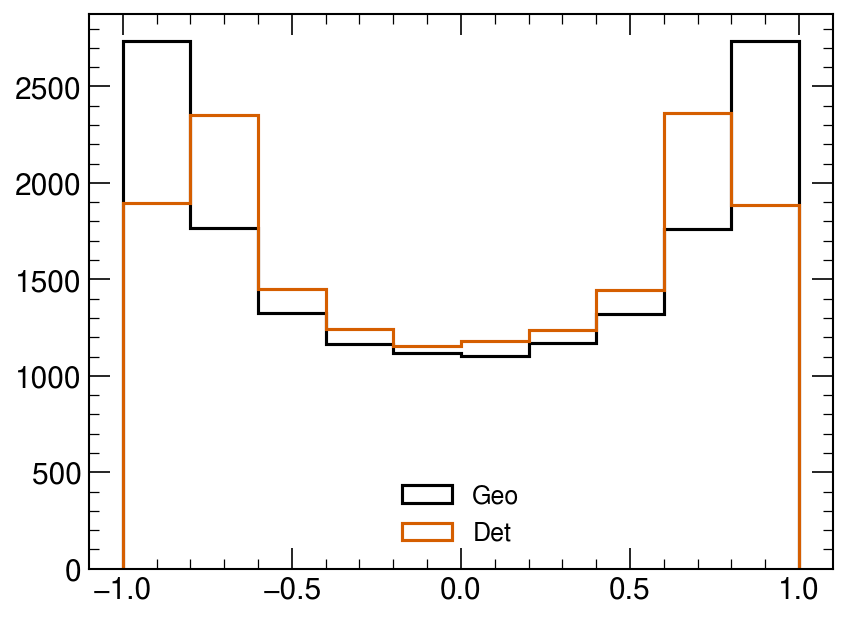

In [6]:
plt.figure(dpi=150)
plt.hist(x, histtype='step',label='Geo')
plt.hist(x_det, histtype='step',label='Det')
plt.legend()
plt.show()

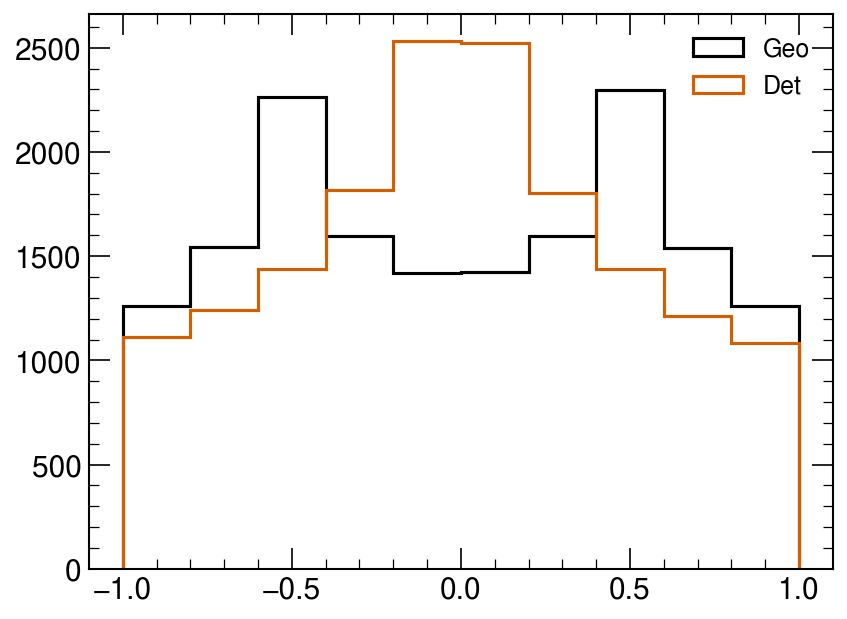

In [7]:
plt.figure(dpi=150)
plt.hist(y, histtype='step',label='Geo')
plt.hist(y_det, histtype='step',label='Det')
plt.legend()
plt.show()

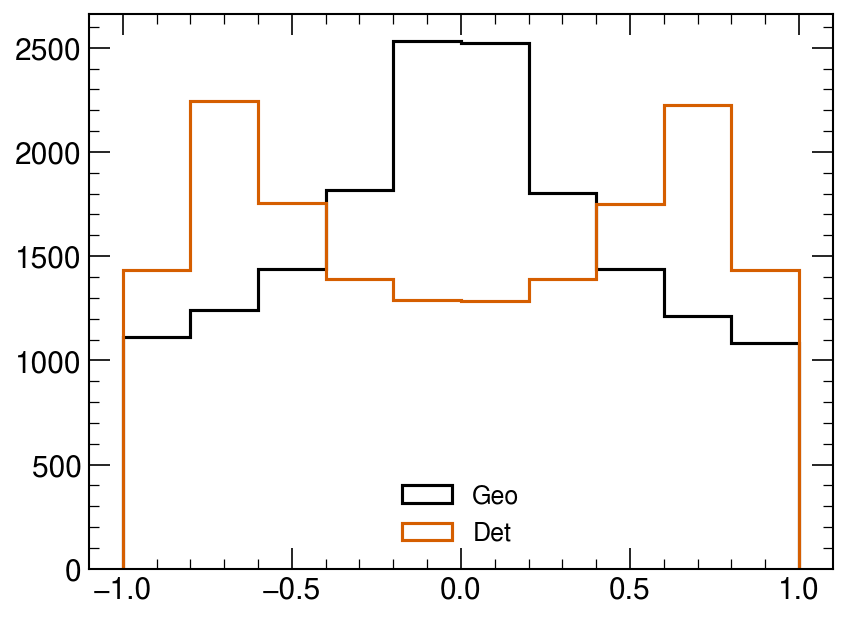

In [8]:
plt.figure(dpi=150)
plt.hist(z, histtype='step',label='Geo')
plt.hist(z_det, histtype='step',label='Det')
plt.legend()
plt.show()

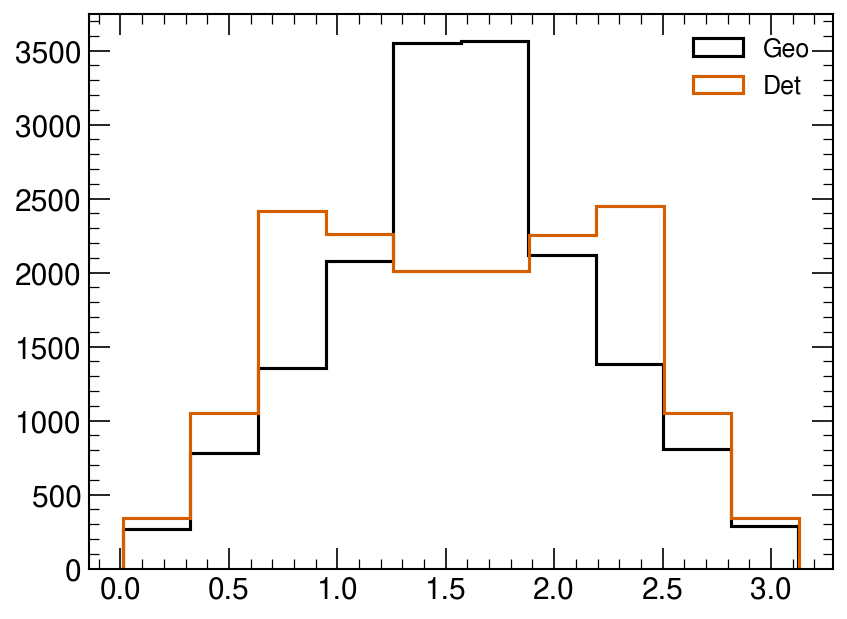

In [9]:
plt.figure(dpi=150)
plt.hist(np.arccos(z), histtype='step',label='Geo')  
plt.hist(np.arccos(z_det), histtype='step',label='Det')
plt.legend()
plt.show()  
   
   #theta_arr.append(np.arccos(z))              # angle from zenith [0, pi]
    #phi_arr.append(np.arctan2(y, x))            # azimuth from south [-pi, pi]
    
        #theta_det_arr.append(np.arccos(z_det))
    #phi_det_arr.append(np.arctan2(y_det, x_det))

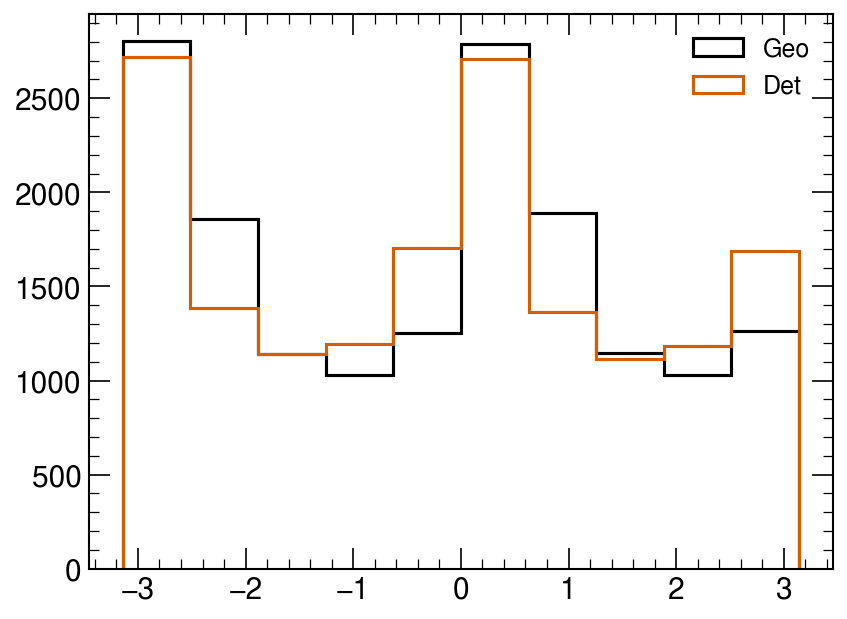

In [11]:
plt.figure(dpi=150)
plt.hist(np.arctan2(y, x), histtype='step',label='Geo')  
plt.hist(np.arctan2(y_det, x_det), histtype='step',label='Det')
plt.legend()
plt.show()  

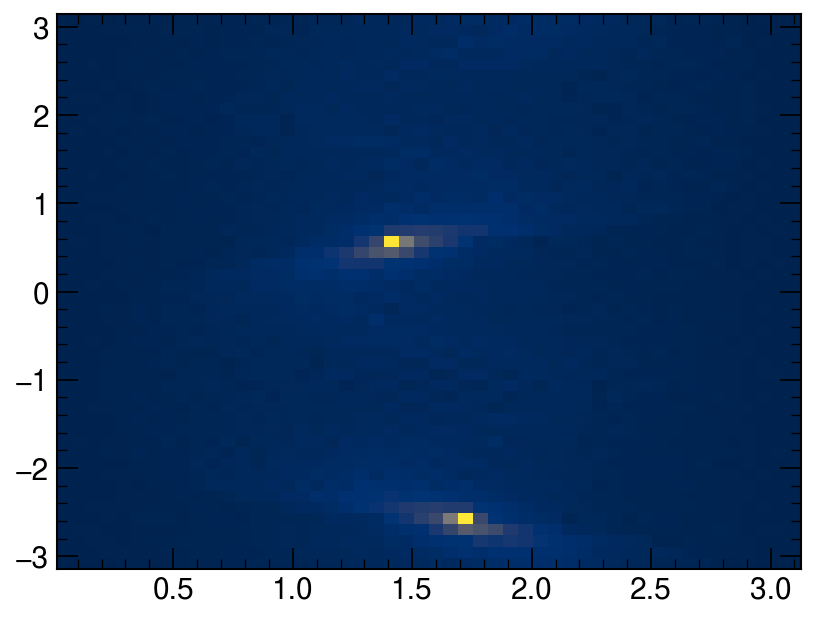

In [14]:
plt.figure(dpi=150)
plt.hist2d(np.arccos(z),np.arctan2(y, x),weights=rho_vals,bins=[50,50])
plt.show()

In [43]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, Galactic
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Constants
r_s = 20.0  # kpc
rho_0 = 0.184  # GeV/cm^3
R_sun = 8.122  # kpc

def rho_NFW(r):
    return rho_0 * (r_s / r) / (1 + r / r_s)**2

def r_galcen(l_deg, b_deg, s):
    l_rad = np.radians(l_deg)
    b_rad = np.radians(b_deg)
    return np.sqrt(R_sun**2 + s**2 - 2 * R_sun * s * np.cos(b_rad) * np.cos(l_rad))

def los_integral(l, b, s_max=300, steps=1000):
    s_vals = np.linspace(0.01, s_max, steps)
    r_vals = r_galcen(l, b, s_vals)
    rho_vals = rho_NFW(r_vals)
    return np.trapz(rho_vals, s_vals)

# --- Grid in Galactic coordinates ---
n_lat = 90
n_lon = 180
l_vals = np.linspace(0, 360, n_lon)
b_vals = np.linspace(-90, 90, n_lat)
L, B = np.meshgrid(l_vals, b_vals)
l_flat = L.flatten()
b_flat = B.flatten()

# --- Time sampling ---
n_times = 10
start_time = Time("2030-01-01 00:00:00")
end_time = start_time + 1 * u.year
times = Time(np.linspace(start_time.jd, end_time.jd, n_times), format='jd')

# --- Detector location ---
location = EarthLocation(lat=44.352*u.deg, lon=-103.751*u.deg, height=100*u.m)

# --- Detector rotation matrix (AltAz → Detector frame) ---
FluxRotValues = np.array([
    [+0.9877, -0.1564, +0.0000],
    [+0.0000, +0.0000, +1.0000],
    [-0.1564, -0.9877, +0.0000]
])

# Accumulate theta, phi, and rho
theta_det_arr = []
phi_det_arr = []
weight_arr = []
gc_theta = []
gc_phi = []

print("Processing sky directions over time...")

for time in tqdm(times):
    for l, b in zip(l_flat, b_flat):
        # Compute LOS integral for this galactic direction
        rho = los_integral(l, b)

        # Transform to AltAz
        gal_coord = SkyCoord(l=l*u.deg, b=b*u.deg, frame='galactic')
        altaz = gal_coord.transform_to(AltAz(obstime=time, location=location))

        if np.isnan(altaz.alt.deg) or altaz.alt.deg < -90 or altaz.alt.deg > 90:
            continue

        alt_rad = np.radians(altaz.alt.deg)
        az_rad = np.radians(altaz.az.deg)

        # Direction vector in AltAz
        x = np.cos(alt_rad) * np.sin(az_rad)
        y = np.cos(alt_rad) * np.cos(az_rad)
        z = np.sin(alt_rad)
        arr_local = np.array([x, y, z])

        # Rotate to detector frame
        arr_det = FluxRotValues @ arr_local
        x_det, y_det, z_det = arr_det
        theta = np.arccos(z_det)
        phi = np.arctan2(y_det, x_det)

        theta_det_arr.append(theta)
        phi_det_arr.append(phi)
        weight_arr.append(rho)

    # Also project the GC for overlay
    gc = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
    altaz_gc = gc.transform_to(AltAz(obstime=time, location=location))
    alt_gc = np.radians(altaz_gc.alt.deg)
    az_gc = np.radians(altaz_gc.az.deg)
    x_gc = np.cos(alt_gc) * np.sin(az_gc)
    y_gc = np.cos(alt_gc) * np.cos(az_gc)
    z_gc = np.sin(alt_gc)
    arr_gc = np.array([x_gc, y_gc, z_gc])
    arr_gc_det = FluxRotValues @ arr_gc
    theta_gc = np.arccos(arr_gc_det[2])
    phi_gc = np.arctan2(arr_gc_det[1], arr_gc_det[0])
    gc_theta.append(theta_gc)
    gc_phi.append(phi_gc)

# Normalize weights
weight_arr = np.array(weight_arr)
weight_arr /= np.max(weight_arr)

# Prepare binning
n_theta_bins = 90
n_phi_bins = 180
theta_edges = np.linspace(0, np.pi, n_theta_bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, n_phi_bins + 1)

Processing sky directions over time...


 10%|█         | 1/10 [00:37<05:37, 37.51s/it]/tmp/ipykernel_11050/1443961676.py:85: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(z_det)
100%|██████████| 10/10 [06:21<00:00, 38.18s/it]


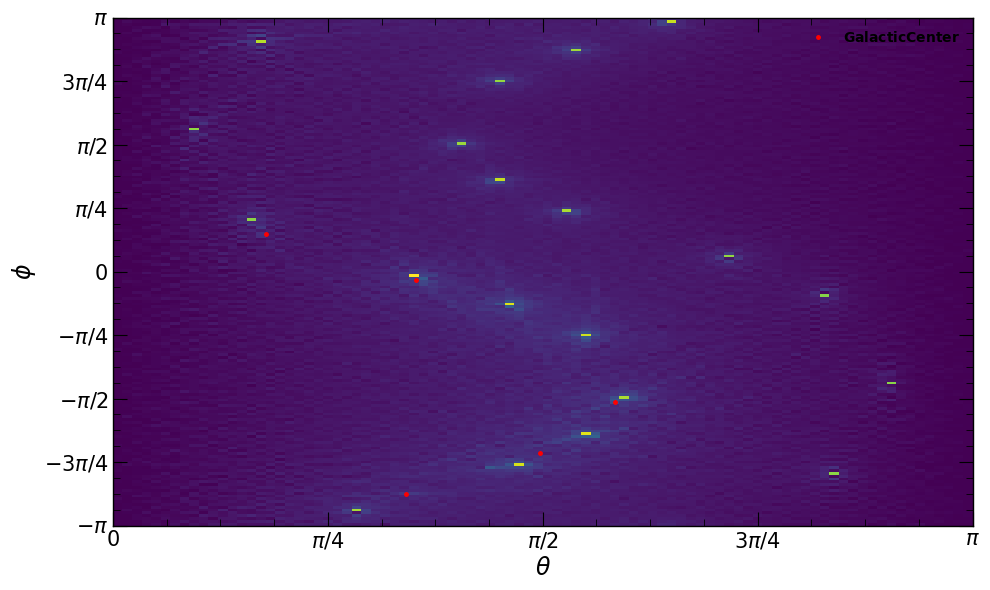

In [54]:
# Plotting
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
h = ax.hist2d(theta_det_arr, phi_det_arr, weights=weight_arr,
              bins=[theta_edges, phi_edges], cmap='viridis')

# Overlay GC track
ax.plot(gc_theta, gc_phi, '.', color='red', markersize=5, label=r'$\bf{Galactic Center}$')

ax.set_xlabel(r'$\theta$', fontsize=17)
ax.set_ylabel(r'$\phi$', fontsize=17)

ax.set_xticks([0.0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels([r'$0$', r'$\pi / 4$', r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize=15)

ax.set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0.0,
                np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_yticklabels([r'$-\pi$', r'$-3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$', r'$0$',
                    r'$\pi / 4$', r'$\pi / 2$', r'$3\pi / 4$', r'$\pi$'], fontsize=15)

#fig.colorbar(h[3], ax=ax, label=r'Normalized $\left< \int \\rho_\mathrm{NFW}(r)\, ds \right>$')
ax.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

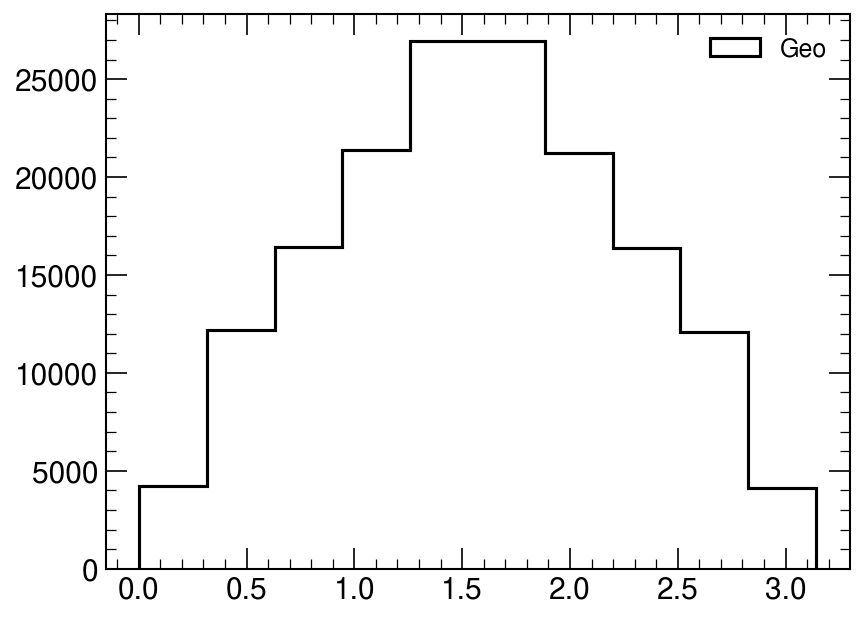

In [ ]:
plt.figure(dpi=150)
plt.hist(theta_det_arr, histtype='step',label='Geo')
plt.legend()
plt.show()

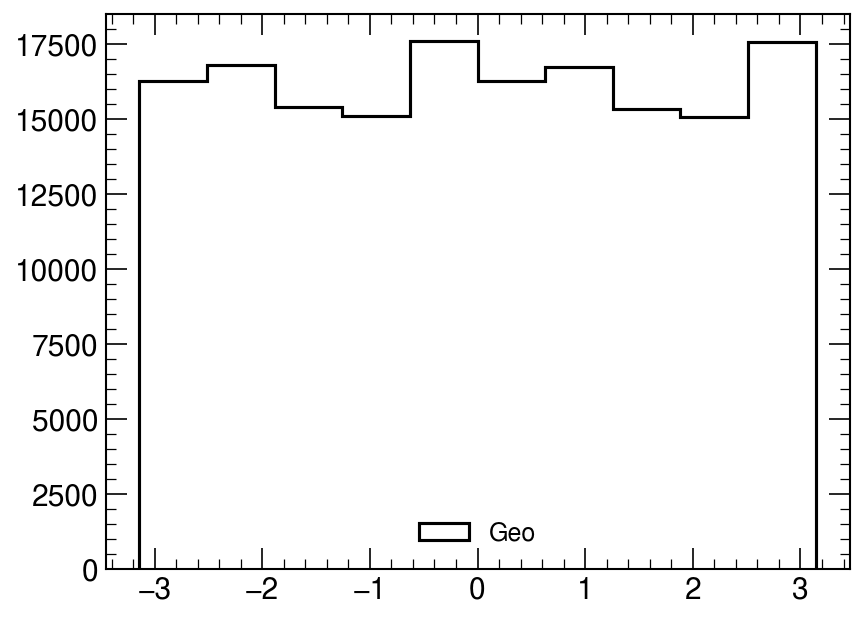

In [52]:
plt.figure(dpi=150)
plt.hist(phi_det_arr, histtype='step',label='Geo')
plt.legend()
plt.show()

Processing AltAz grid across multiple times...


100%|██████████| 5/5 [02:44<00:00, 32.97s/it]


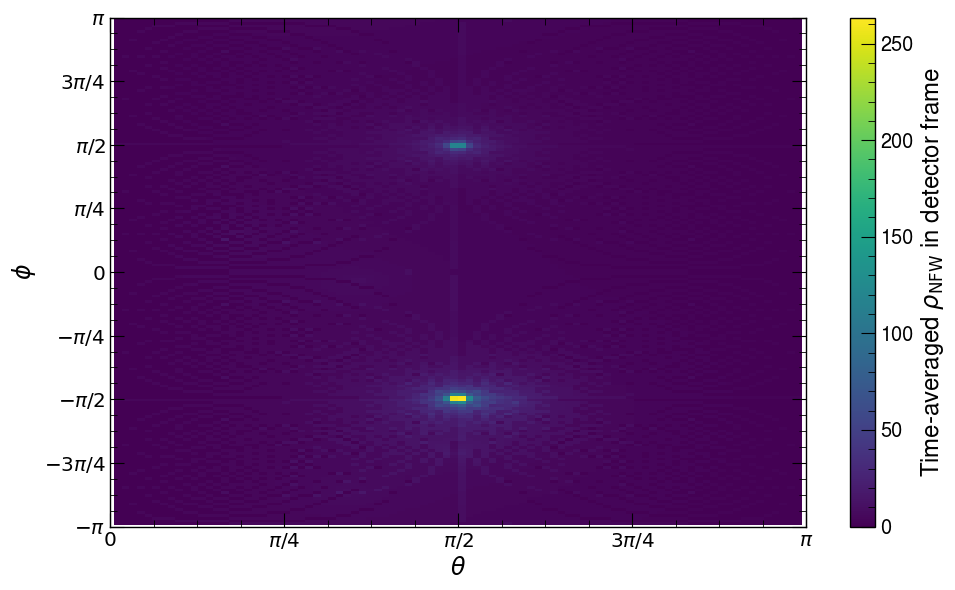

In [62]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, Galactic
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Constants
r_s = 20.0  # kpc
rho_0 = 0.184  # GeV/cm^3
R_sun = 8.122  # kpc

def rho_NFW(r):
    return rho_0 * (r_s / r) / (1 + r / r_s)**2

def r_galcen(l_deg, b_deg, s):
    l_rad = np.radians(l_deg)
    b_rad = np.radians(b_deg)
    return np.sqrt(R_sun**2 + s**2 - 2 * R_sun * s * np.cos(b_rad) * np.cos(l_rad))

def los_integral(l, b, s_max=300, steps=1000):
    s_vals = np.linspace(0.01, s_max, steps)
    r_vals = r_galcen(l, b, s_vals)
    rho_vals = rho_NFW(r_vals)
    return np.trapz(rho_vals, s_vals)

# Detector location
location = EarthLocation(lat=44.352*u.deg, lon=-103.751*u.deg, height=100*u.m)

# Time range
n_times = 5
start_time = Time("2030-01-01 00:00:00")
end_time = start_time + 1 * u.year
times = Time(np.linspace(start_time.jd, end_time.jd, n_times), format='jd')

# AltAz grid
n_alt_bins = 90
n_az_bins = 180
alt_edges = np.linspace(-90, 90, n_alt_bins + 1)
az_edges = np.linspace(0, 360, n_az_bins + 1)
alt_centers = 0.5 * (alt_edges[:-1] + alt_edges[1:])
az_centers = 0.5 * (az_edges[:-1] + az_edges[1:])
ALT, AZ = np.meshgrid(alt_centers, az_centers)
ALT_flat = ALT.flatten()
AZ_flat = AZ.flatten()

# Rotation matrix AltAz to Detector
FluxRotValues = np.array([
    [+0.9877, -0.1564, +0.0000],
    [+0.0000, +0.0000, +1.0000],
    [-0.1564, -0.9877, +0.0000]
])

# Precompute AltAz unit vectors
arr_local = []
for alt, az in zip(ALT_flat, AZ_flat):
    alt_rad = np.radians(alt)
    az_rad = np.radians(az)
    x = np.cos(alt_rad) * np.sin(az_rad)
    y = np.cos(alt_rad) * np.cos(az_rad)
    z = np.sin(alt_rad)
    arr_local.append([x, y, z])

arr_local = np.array(arr_local).T  # shape (3, N)
arr_local_unit = arr_local / np.linalg.norm(arr_local, axis=0, keepdims=True)

# Accumulate rotated rho values
rho_vals_accum = np.zeros(arr_local.shape[1])

print("Processing AltAz grid across multiple times...")

for time in tqdm(times):
    rho_vals = []
    for alt, az in zip(ALT_flat, AZ_flat):
        altaz = AltAz(alt=alt*u.deg, az=az*u.deg, obstime=time, location=location)
        gal = altaz.transform_to(Galactic())
        l_deg = gal.l.deg
        b_deg = gal.b.deg
        rho = los_integral(l_deg, b_deg)
        rho_vals.append(rho)

    rho_vals = np.array(rho_vals)

    # Rotate vectors to detector frame
    arr_det = FluxRotValues @ arr_local
    arr_det_unit = arr_det / np.linalg.norm(arr_det, axis=0, keepdims=True)

    # Reassign rotated rho to original grid
    for i in range(arr_det_unit.shape[1]):
        v_det = arr_det_unit[:, i]
        dots = arr_local_unit.T @ v_det
        j = np.argmax(dots)
        rho_vals_accum[j] += rho_vals[i]

# Normalize
rho_vals_avg = rho_vals_accum / n_times

# Plot
theta = np.arccos(arr_local_unit[2])
phi = np.arctan2(arr_local_unit[1], arr_local_unit[0])
phi = np.mod(phi + np.pi, 2*np.pi) - np.pi

fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
h = ax.hist2d(theta, phi, weights=rho_vals_avg, bins=[90, 180], cmap='viridis')

ax.set_xlabel(r'$\theta$', fontsize=17)
ax.set_ylabel(r'$\phi$', fontsize=17)
ax.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels([r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])
ax.set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_yticklabels([r'$-\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'$-\pi/4$', r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])
fig.colorbar(h[3], ax=ax, label=r'Time-averaged $\rho_\mathrm{NFW}$ in detector frame')
plt.tight_layout()
plt.show()